In [1]:
import pandas as pd
import random
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import re
import re
import nltk
import pandas as pd
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from simpletransformers.classification import ClassificationModel, ClassificationArgs


## Loading Data

In [2]:
df = pd.read_csv('https://query.data.world/s/sktr44jfdxwsht2quuczc2yldirizz', encoding = "ISO-8859-1" )#, engine='python') #, encoding="0x89")

In [3]:
amounts = ['$200 ', '$400 ', '$600 ', '$800 ', '$1,000 ', '$1,200 ', '$1,600 ', '$2,000 ']

# make sure only rows with set values
df_reg = df[df['Value'].isin(amounts)]

# not null values
df_reg = df_reg[df_reg['Value'].notnull()]

In [4]:
#######################
# Create Ordinal Mapping for Y Labels
value_mapping = {'$200 ': 0, '$400 ': 1, '$600 ': 2,
     '$800 ': 3, '$1,000 ': 4, '$1,200 ': 5,
     '$1,600 ': 6, '$2,000 ': 7}

df_reg['value_order'] = df_reg.Value.map(value_mapping).astype(int)


#######################
# Create text using Category, Answer and Question

df_reg['text'] = ''

for i, row in df_reg.iterrows():
    text = ''
    if type(row['Category']) == str:
        text = text + row['Category']
    if type(row['Answer']) == str:
        text = text + ' ' + row['Answer']
    if type(row['Question']) == str:
        text = text + ' ' + row['Question']
    df_reg.loc[i,'text'] = text
    

#######################
# Create a version 2 of Jeopardy questions

    
df_reg['value_order2'] = df_reg['value_order']

for i, row in df_reg.iterrows():
    value = row['Value'].strip()
    value_order = row['value_order']
    if row['Round'].strip() == 'Double Jeopardy!':
        if value == '$400':
            value_order = 0
        elif value == '$800':
            value_order = 1
        elif value == '$1,200':
            value_order = 2
        elif value == '$1,600':
            value_order = 3
        elif value == '$2,000':
            value_order = 4
        df_reg.loc[i,'value_order2'] = value_order
        
df_reg.head()

,Show_Number,Air_Date,Round,Category,Value,Question,Answer,value_order,text,value_order2
0,4680,12/31/04,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,0,HISTORY Copernicus For the last 8 years of his...,0
1,4680,12/31/04,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,0,ESPN's TOP 10 ALL-TIME ATHLETES Jim Thorpe No....,0
2,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,0,EVERYBODY TALKS ABOUT IT... Arizona The city o...,0
3,4680,12/31/04,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,0,"THE COMPANY LINE McDonald's In 1963, live on ""...",0
4,4680,12/31/04,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,0,EPITAPHS & TRIBUTES John Adams Signer of the D...,0


In [5]:
########################
# Removing incorrect data anomalies

incorrect_data = df_reg.value_order2.isin([5,6,7])
df_reg2 = df_reg[~incorrect_data]

In [6]:
########################
# Fixing Uneven Classification data
print(df_reg2.groupby(['value_order2'])['Show_Number'].agg(['count']))

df_reg2_0 = df_reg2[df_reg2['value_order2'] == 0].sample(22956)
df_reg2_1 = df_reg2[df_reg2['value_order2'] == 1].sample(22956)
df_reg2_2 = df_reg2[df_reg2['value_order2'] == 2].sample(22956)
df_reg2_3 = df_reg2[df_reg2['value_order2'] == 3]
df_reg2_4 = df_reg2[df_reg2['value_order2'] == 4].sample(22956)


df_reg3 = pd.concat([df_reg2_0, df_reg2_1, df_reg2_2, df_reg2_3, df_reg2_4])


              count
value_order2       
0             51743
1             40812
2             31979
3             22956
4             34225


In [7]:
########################
# Limiting words to make it compatible with BERT model

df_bert2 = df_reg3

df_bert2.loc[:,'text2'] = ''

for i, row in df_bert2.iterrows():
    words = row['text'].split(' ')
    if len(words) > 200:
        words = words[:200]
    df_bert2.loc[i,'text2'] = ' '.join(words)
    
df_bert2

,Show_Number,Air_Date,Round,Category,Value,Question,Answer,value_order,text,value_order2,text2
14045,3621,5/8/00,Double Jeopardy!,COUNTRIES BY CAPITAL,$200,In the Americas: Caracas,Venezuela,0,COUNTRIES BY CAPITAL Venezuela In the Americas...,0,COUNTRIES BY CAPITAL Venezuela In the Americas...
121857,6057,1/4/11,Jeopardy!,3 AGAINST 1,$200,"British theater director Trevor, or ex-Georgia...",Nunn,0,3 AGAINST 1 Nunn British theater director Trev...,0,3 AGAINST 1 Nunn British theater director Trev...
149410,4240,1/24/03,Jeopardy!,PRESIDENTIAL RHYME TIME,$200,Clinton's aspirins,Bill's pills,0,PRESIDENTIAL RHYME TIME Bill's pills Clinton's...,0,PRESIDENTIAL RHYME TIME Bill's pills Clinton's...
74116,2824,12/5/96,Jeopardy!,LITERARY HODGEPODGE,$200,"Once a naval historian in the south Pacific, h...",James Michener,0,LITERARY HODGEPODGE James Michener Once a nava...,0,LITERARY HODGEPODGE James Michener Once a nava...
185582,3078,1/7/98,Double Jeopardy!,DIBS!,$400,"The Dutch had already sighted Australia, & Abo...",Captain James Cook,1,DIBS! Captain James Cook The Dutch had already...,0,DIBS! Captain James Cook The Dutch had already...
...,...,...,...,...,...,...,...,...,...,...,...
26932,4892,12/13/05,Jeopardy!,NFL NICKNAMES,"$1,000","""Sweetness""",Walter Payton,4,"NFL NICKNAMES Walter Payton ""Sweetness""",4,"NFL NICKNAMES Walter Payton ""Sweetness"""
10940,3588,3/22/00,Double Jeopardy!,COUNTIES OF ENGLAND,"$1,000","The westernmost county of England, or what the...",Cornwall,4,COUNTIES OF ENGLAND Cornwall The westernmost c...,4,COUNTIES OF ENGLAND Cornwall The westernmost c...
76032,5418,3/12/08,Double Jeopardy!,THROWDOWN WITH BOBBY FLAY,"$2,000","(<a href=""http://www.j-archive.com/media/2008-...",caramelized,7,THROWDOWN WITH BOBBY FLAY caramelized (<a href...,4,THROWDOWN WITH BOBBY FLAY caramelized (<a href...
199752,2851,1/13/97,Double Jeopardy!,SCIENTISTS,"$1,000",This Hungarian-American physicist was the prin...,Edward Teller,4,SCIENTISTS Edward Teller This Hungarian-Americ...,4,SCIENTISTS Edward Teller This Hungarian-Americ...


## Data Exploration

In [ ]:
t = pd.CategoricalDtype(categories=amounts, ordered=True)
df_reg['Value'] = df_reg['Value'].astype(t)

# get year from air_date
df['Year'] = pd.to_datetime(df['Air_Date'], format='%m/%d/%y').dt.year

In [ ]:
def agg_count(df, group_field):
    grouped = df.groupby(group_field, as_index=False).size()
#     grouped.sort(ascending = False)

    grouped = pd.DataFrame(grouped).reset_index()
    grouped.columns = [group_field, 'Count']
    return grouped

In [ ]:
category_counts = agg_count(df_reg, 'Value')

category_counts_og = agg_count(df, 'Value')
category_counts_og = category_counts_og.sort_values(by='Count', ascending=False)[0:10]

#####################
# Jeopardy1 is first jeopardy round
# Jeopardy2 is double jeopardy round
jeopardy1 = df[df['Round'] == 'Jeopardy!']
jeopardy2 = df[df['Round'] == 'Double Jeopardy!']

#####################
# Finding values which are not typical
category_counts_og_1 = agg_count(jeopardy1[~jeopardy1['Value'].isin(amounts)], 'Value')
category_counts_og_1 = category_counts_og_1.sort_values(by='Count', ascending=False)[0:10]

category_counts_og_2 = agg_count(jeopardy2[~jeopardy2['Value'].isin(amounts)], 'Value')
category_counts_og_2 = category_counts_og_2.sort_values(by='Count', ascending=False)[0:10]

#####################
# Finding years when irregular values occurrred 
category_counts_og_3 = agg_count(jeopardy1[~jeopardy1['Value'].isin(amounts)], 'Year')
category_counts_og_3 = category_counts_og_3.sort_values(by='Count', ascending=False)[0:10]

category_counts_og_4 = agg_count(jeopardy2[~jeopardy2['Value'].isin(amounts)], 'Year')
category_counts_og_4 = category_counts_og_4.sort_values(by='Count', ascending=False)[0:10]

In [ ]:
category_counts_og_4

In [ ]:
#########################
# Printing What a Question & Answer look like

print(jeopardy1[:1])

for letter in jeopardy1['Question'][:1]:
    print(letter)
    
print()

for letter in jeopardy1['Answer'][:1]:
    print(letter)

## Data Visualization

In [ ]:
category_counts_og = category_counts_og.sort_values(by='Count', ascending=False)[0:10]

In [ ]:
#############################
# Distribution of Typical Jeopardy Values

ax = sns.barplot(data=category_counts, x="Count", y="Value")
ax.set(xlabel='\n Number of Questions')
plt.title('Jeopardy Questions by Value \n')

In [ ]:
#############################
# Distribution of ALL Jeopardy Values

ax = sns.barplot(data=category_counts_og, x="Count", y="Value")
ax.set(xlabel='\n Number of Questions')
plt.title('Jeopardy Questions by Value \n')

In [ ]:
#############################
# Distribution of Irregular Jeopardy Values
## First Round

ax = sns.barplot(data=category_counts_og_1, x="Count", y="Value")
# ax = sns.barplot(data=category_counts_og_3, x="Count", y="Year")
ax.set(xlabel='\n Number of Questions')
plt.title('Jeopardy Questions by Value \n')

In [ ]:
#############################
# Distribution of Typical Jeopardy Values
## Second Round (Double Jeopardy)

ax = sns.barplot(data=category_counts_og_2, x="Count", y="Value")
ax.set(xlabel='\n Number of Questions')
plt.title('Jeopardy Questions by Value \n')

# CountVectorizer --> CAN SKIP THIS

In [ ]:
######################
# put questions in a list
######################
cat_in_the_hat_docs = df_reg.Question.tolist()
# type(cat_in_the_hat_docs)

######################
# Vectorize questions
######################
cv = CountVectorizer(cat_in_the_hat_docs)
count_vector=cv.fit_transform(cat_in_the_hat_docs)

# show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
# print(cv.vocabulary_)

#shape of count vector: 5 docs (book titles) and 43 unique words
print(count_vector.shape)

######################
# stop words
######################
cv = CountVectorizer(cat_in_the_hat_docs,stop_words=["all","in","the","is","and"])
count_vector=cv.fit_transform(cat_in_the_hat_docs)
print(count_vector.shape)

# any stop words that we explicitly specified?
# print(cv.stop_words)

######################
# ignore terms that appeared in less than 2 documents 
######################
cv = CountVectorizer(cat_in_the_hat_docs,min_df=2)
count_vector=cv.fit_transform(cat_in_the_hat_docs)

######################
# ignore terms that appear in 50% of the documents
######################
cv = CountVectorizer(cat_in_the_hat_docs,max_df=0.50)
count_vector=cv.fit_transform(cat_in_the_hat_docs)

In [ ]:
def my_tokenizer(text):
    # create a space between special characters 
    text=re.sub("(\\W)"," \\1 ",text)

    # split based on whitespace
    return re.split("\\s+",text)
    

cv = CountVectorizer(cat_in_the_hat_docs,tokenizer=my_tokenizer)
count_vector=cv.fit_transform(cat_in_the_hat_docs)
# print(cv.vocabulary_)

### Apply processing and shape data (unigram & bigram)

In [ ]:
# using my_cool_preprocessor
cv1 = CountVectorizer(cat_in_the_hat_docs,preprocessor=my_cool_preprocessor)
count_vector1=cv1.fit_transform(cat_in_the_hat_docs)

In [ ]:
# only bigrams, word level
cv2 = CountVectorizer(cat_in_the_hat_docs,ngram_range=(2,2),preprocessor=my_cool_preprocessor)
count_vector2=cv2.fit_transform(cat_in_the_hat_docs)

In [ ]:
# unigrams and bigrams, word level
cv3 = CountVectorizer(cat_in_the_hat_docs,ngram_range=(1,2),preprocessor=my_cool_preprocessor)
count_vector3=cv3.fit_transform(cat_in_the_hat_docs)

## Defining Functions

In [ ]:
# init stemmer
porter_stemmer=PorterStemmer()

def my_cool_preprocessor(text):
    
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    
    # stem words
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)


In [8]:
def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
#     logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

# Logistic Regression

# Train model

In [9]:
import numpy as np

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]

    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]

    # REVERSE CATEGORIES - DESCENDING ORDER OF IMPORTANCE
    preds=[ item[::-1][0] for item in preds]

    return preds


In [10]:
df_reg3

,Show_Number,Air_Date,Round,Category,Value,Question,Answer,value_order,text,value_order2,text2
14045,3621,5/8/00,Double Jeopardy!,COUNTRIES BY CAPITAL,$200,In the Americas: Caracas,Venezuela,0,COUNTRIES BY CAPITAL Venezuela In the Americas...,0,COUNTRIES BY CAPITAL Venezuela In the Americas...
121857,6057,1/4/11,Jeopardy!,3 AGAINST 1,$200,"British theater director Trevor, or ex-Georgia...",Nunn,0,3 AGAINST 1 Nunn British theater director Trev...,0,3 AGAINST 1 Nunn British theater director Trev...
149410,4240,1/24/03,Jeopardy!,PRESIDENTIAL RHYME TIME,$200,Clinton's aspirins,Bill's pills,0,PRESIDENTIAL RHYME TIME Bill's pills Clinton's...,0,PRESIDENTIAL RHYME TIME Bill's pills Clinton's...
74116,2824,12/5/96,Jeopardy!,LITERARY HODGEPODGE,$200,"Once a naval historian in the south Pacific, h...",James Michener,0,LITERARY HODGEPODGE James Michener Once a nava...,0,LITERARY HODGEPODGE James Michener Once a nava...
185582,3078,1/7/98,Double Jeopardy!,DIBS!,$400,"The Dutch had already sighted Australia, & Abo...",Captain James Cook,1,DIBS! Captain James Cook The Dutch had already...,0,DIBS! Captain James Cook The Dutch had already...
...,...,...,...,...,...,...,...,...,...,...,...
26932,4892,12/13/05,Jeopardy!,NFL NICKNAMES,"$1,000","""Sweetness""",Walter Payton,4,"NFL NICKNAMES Walter Payton ""Sweetness""",4,"NFL NICKNAMES Walter Payton ""Sweetness"""
10940,3588,3/22/00,Double Jeopardy!,COUNTIES OF ENGLAND,"$1,000","The westernmost county of England, or what the...",Cornwall,4,COUNTIES OF ENGLAND Cornwall The westernmost c...,4,COUNTIES OF ENGLAND Cornwall The westernmost c...
76032,5418,3/12/08,Double Jeopardy!,THROWDOWN WITH BOBBY FLAY,"$2,000","(<a href=""http://www.j-archive.com/media/2008-...",caramelized,7,THROWDOWN WITH BOBBY FLAY caramelized (<a href...,4,THROWDOWN WITH BOBBY FLAY caramelized (<a href...
199752,2851,1/13/97,Double Jeopardy!,SCIENTISTS,"$1,000",This Hungarian-American physicist was the prin...,Edward Teller,4,SCIENTISTS Edward Teller This Hungarian-Americ...,4,SCIENTISTS Edward Teller This Hungarian-Americ...


In [11]:
# GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(df_reg3,random_state = 2000)

# GET LABELS
Y_train=training_data['value_order2'].values
Y_test=testing_data['value_order2'].values
     
# GET FEATURES
# field = 'Value'
field = 'text2'
X_train,X_test,feature_transformer=extract_features(df_reg3,field,training_data,testing_data,type="TF-IDF")


In [12]:
# INIT LOGISTIC REGRESSION CLASSIFIER

# logging.info("Training a Logistic Regression Model...")
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)

model=scikit_log_reg.fit(X_train,Y_train)

[LibLinear]

In [13]:
# GET TOP K PREDICTIONS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

top_k = 1
preds=get_top_k_predictions(model,X_test,top_k)
    
# GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS
# eval_items=collect_preds(Y_test,preds)
    
# GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
# logging.info("Starting evaluation...")
# accuracy=compute_accuracy(eval_items)
# mrr_at_k=compute_mrr_at_k(eval_items)


# accuracy = accuracy_score(Y_test, preds)

In [14]:
from sklearn.metrics import f1_score

accuracy = accuracy_score(Y_test.tolist(), preds)
print(accuracy)

f1 = f1_score(Y_test.tolist(), preds, average='weighted')
print(f1)

# confusion_matrix(Y_test.tolist(), preds)

0.2167276529012023
0.21639007702297622


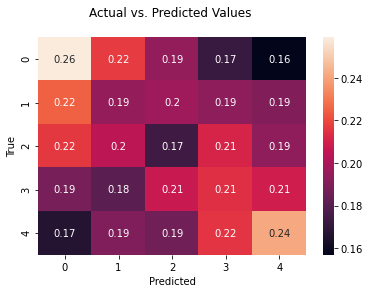

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

amounts = [0, 1, 2, 3, 4]


cm = confusion_matrix(Y_test.tolist(), preds ) #, labels=amounts)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn)
cm_df.columns = amounts
cm_df.columns.name = 'Predicted'
cm_df.index = amounts
cm_df.index.name = 'True'

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xticklabels([''] + amounts)
ax.set_yticklabels([''] + amounts)

plt.xlabel('Predicted')
plt.ylabel('True')

sns.heatmap(cm_df, annot=True)

plt.title('Actual vs. Predicted Values \n')
plt.show()

# Pre-Trained Models: Bert

In [ ]:
!pip install "simpletransformers==0.60.9"

In [10]:
# GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(df_reg3,random_state = 2000)
testing = testing_data[['text2', 'value_order']]
training = training_data[['text2', 'value_order']]

In [57]:

model_args = ClassificationArgs(num_train_epochs=2,
                               overwrite_output_dir=True)

#Create a ClassificationModel
model = ClassificationModel(
                            'distilbert', 'distilbert-base-uncased',
                            num_labels=8,
                            args=model_args)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [58]:
model.train_model(training, output_dir = 'question_answer_output')

(21522, 1.9777870533103206)

In [8]:
##############################
# How to reload model once it's already trained

model = ClassificationModel("distilbert", "question_answer_output/checkpoint-21522-epoch-2")

In [11]:
scores1, model_outputs, wrong_predictions = model.eval_model(testing)
scores1

/home/awisk/.local/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


{'mcc': 0.0659090956000719, 'eval_loss': 1.9511454489558795}

In [12]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')


In [13]:
scores2, model_outputs, wrong_predictions = model.eval_model(testing, f1=f1_multiclass, acc=accuracy_score)
scores2

{'mcc': 0.0659090956000719,
 'f1': 0.23052796654469418,
 'acc': 0.2305279665446942,
 'eval_loss': 1.9511454489558795}

In [14]:
predictions, raw_outputs = model.predict(testing.iloc[:,0].tolist())

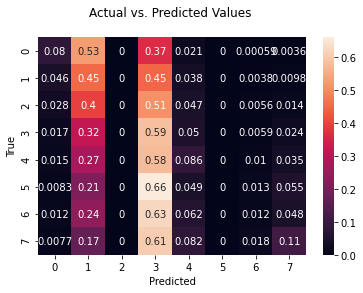

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


amounts2 = [0, 1, 2, 3, 4, 5, 6, 7]

cm = confusion_matrix(testing.iloc[:,1].tolist(), predictions ) #, labels=amounts)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn)
cm_df.columns = amounts2
cm_df.columns.name = 'Predicted'
cm_df.index = amounts2
cm_df.index.name = 'True'

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xticklabels([''] + amounts2)
ax.set_yticklabels([''] + amounts2)

plt.xlabel('Predicted')
plt.ylabel('True')

sns.heatmap(cm_df, annot=True)

plt.title('Actual vs. Predicted Values \n')
plt.show()

## BERT Version 2

In [19]:
# GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(df_bert2,random_state = 2000)
training = training_data[['text2', 'value_order2']]
testing = testing_data[['text2', 'value_order2']]
training

,text2,value_order2
109443,BRAND NAMES Nikon The company that sold Nikkor...,1
191689,"HUMPTY DUMPTY Tori Amos ""Cornflake Girl' who w...",2
68421,"STATE MOTTOES New York ""Excelsior""",2
107944,SYMPHONY SPACE the Royal Albert Hall In 2008 t...,1
62466,ORIGINAL PRANKSTA the Cardiff Giant Unearthed ...,4
...,...,...
634,"""T""ELEVISION Touched by an Angel Reminiscent o...",1
6717,GETTING TICKED OFF Bismarck Jealous of this Pr...,3
47743,ETHICS bioethics Washington Hospital Center ha...,2
78589,FOREIGN FOOD breakfast Meal at which you'd nor...,1


In [35]:
model_args = ClassificationArgs(num_train_epochs=2,
#                                 max_seq_length = 1024,
                               overwrite_output_dir=True)

#Create a ClassificationModel
model = ClassificationModel(
                            'distilbert', 'distilbert-base-uncased',
#                             'scibert', 'allenai/scibert_scivocab_uncased',                      
                            num_labels=5,
                            args=model_args)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [36]:
model.train_model(training, output_dir = 'value_5_output')

/home/awisk/.local/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:445: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


(21522, 1.5808934402193304)

In [30]:
##############################
# How to reload model once it's already trained

model = ClassificationModel(
    "distilbert", "value_5_output/checkpoint-21522-epoch-2"
)

In [22]:
scores1, model_outputs, wrong_predictions = model.eval_model(testing)
scores1

/home/awisk/.local/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


{'mcc': 0.09923540377777623, 'eval_loss': 1.5662460075569313}

In [38]:
scores2, model_outputs, wrong_predictions = model.eval_model(testing, f1=f1_multiclass, acc=accuracy_score)
scores2

{'mcc': 0.06845732061419518,
 'f1': 0.25370273566823487,
 'acc': 0.25370273566823487,
 'eval_loss': 1.593196719876564}

In [43]:
testing.iloc[:,[0]]

,text2
40981,ON YOUR SLEEVE tattoos Actor Dwayne Johnson ha...
101154,"COMMON BONDS knives Butter, Carving, Steak"
75398,REPORTING FROM THE WHITE HOUSE the Camp David ...
18548,MUSICAL DICTIONARY the bell The wide end of a ...
31983,LITERATI William Faulkner This writer's great-...
...,...
157260,"EDIBLE COMMON BONDS sauces Brown, beurre-blanc..."
48133,GO TELL IT ON THE MOUNTAIN the Sierra Madre Yo...
61635,CAPITAL RIVERS the Mekong Vientiane
190137,"A LITTLE ""R"" & ""R"" Rhodesian Ridgeback This po..."


In [31]:
predictions, raw_outputs = model.predict(testing.iloc[:,0].tolist())

In [34]:
raw_outputs

array([[ 0.56445312,  0.23608398,  0.04830933, -0.53027344, -0.27197266],
       [ 0.89648438,  0.46533203,  0.07568359, -0.54492188, -0.71191406],
       [ 0.1907959 ,  0.10021973,  0.00317383, -0.63476562,  0.24682617],
       ...,
       [-0.27563477, -0.05963135,  0.08544922,  0.21728516, -0.00338936],
       [-0.45043945, -0.04782104,  0.18041992,  0.4050293 , -0.10772705],
       [ 0.91503906,  0.40649414,  0.04641724, -0.60009766, -0.61914062]])

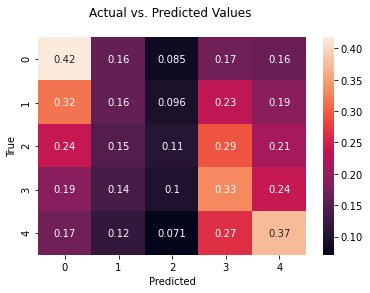

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


amounts2 = [0, 1, 2, 3, 4]

cm = confusion_matrix(testing.iloc[:,1].tolist(), predictions ) #, labels=amounts)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn)
cm_df.columns = amounts2
cm_df.columns.name = 'Predicted'
cm_df.index = amounts2
cm_df.index.name = 'True'

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xticklabels([''] + amounts2)
ax.set_yticklabels([''] + amounts2)

plt.xlabel('Predicted')
plt.ylabel('True')

sns.heatmap(cm_df, annot=True)

plt.title('Actual vs. Predicted Values \n')
plt.show()

# SciBERT

In [47]:
model_args = ClassificationArgs(num_train_epochs=2,
                               overwrite_output_dir=True)

#Create a ClassificationModel
model = ClassificationModel(
                            'bert', 'allenai/scibert_scivocab_uncased',                      
                            num_labels=5,
                            args=model_args)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [48]:
model.train_model(training, output_dir = 'scibert_output')

/home/awisk/.local/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:445: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


(21522, 1.6252723706830956)

In [26]:
##############################
# How to reload model once it's already trained

model = ClassificationModel(
    "bert", "scibert_output/checkpoint-21522-epoch-2"
)

In [27]:
scores1, model_outputs, wrong_predictions = model.eval_model(testing)
scores1

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


{'mcc': 0.0, 'eval_loss': 1.610702323587884}

In [50]:
scores2, model_outputs, wrong_predictions = model.eval_model(testing, f1=f1_multiclass, acc=accuracy_score)
scores2

{'mcc': 0.0,
 'f1': 0.19947726084683742,
 'acc': 0.19947726084683742,
 'eval_loss': 1.6106858047097714}

In [28]:
predictions, raw_outputs = model.predict(testing.iloc[:,0].tolist())

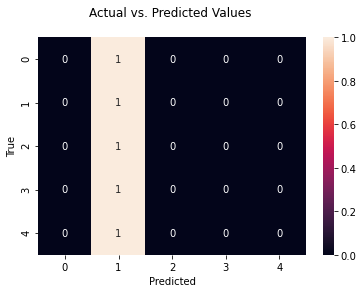

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


amounts2 = [0, 1, 2, 3, 4]

cm = confusion_matrix(testing.iloc[:,1].tolist(), predictions ) #, labels=amounts)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn)
cm_df.columns = amounts2
cm_df.columns.name = 'Predicted'
cm_df.index = amounts2
cm_df.index.name = 'True'

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xticklabels([''] + amounts2)
ax.set_yticklabels([''] + amounts2)

plt.xlabel('Predicted')
plt.ylabel('True')

sns.heatmap(cm_df, annot=True)

plt.title('Actual vs. Predicted Values \n')
plt.show()